In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import importlib
import matplotlib
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import sys
import os

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import snn_lib.utilities as utilities
from snn_lib.snn_layers import *

# Configurations

In [ ]:
dataset_path = './dataset/associative_target.npy'

checkpoint_base_name = "associative_memory_checkpoint_"
checkpoint_base_path = './checkpoint/'

torch.manual_seed(2)
np.random.seed(0)

length = 300
input_size = 300
batch_size = 64
synapse_type = 'dual_exp'
epoch = 50
tau_m = 8
tau_s = 2
filter_tau_m = tau_m
filter_tau_s = tau_s
dropout_rate = 0.3

modify_input_prob = 0.6
remove_prob = 0.5
remove_row_prob = 0.2
remove_col_prob = 0.2
remove_block_prob = 0.2
mutate_prob = 0.7
noise_prob = 0.005

remove_block_h = 30
remove_block_w = 40
remove_block_h = 40
remove_col_w = 30
remove_row_h = 30

optimizer_choice = 1
scheduler_choice = 1

optimizer_config = {0: (torch.optim.Adam,       0.001),
                    1: (torch.optim.AdamW,      0.001),
                    2: (torch.optim.SGD,        0.0001)}

scheduler_config = {0: None,
                    1: (torch.optim.lr_scheduler.MultiStepLR, [50,100, 150], 0.1),
                    # order: milestones, gamma=0.1
                    2: (torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, 1000),
                    # T_0
                    3: (torch.optim.lr_scheduler.CyclicLR, 0.001, 0.01, 200)
                    }

# Prepare dataset

In [ ]:
# %% utility functions
def add_noise_spike(spike_array,probability = 0.003):
    '''
    :param spike_array: 2d array [spike train num, length]
    :param probability:
    :return:
    '''
    noise_mat = np.random.rand(*spike_array.shape).astype(np.float32)

    noise_mat[np.where(noise_mat > 1-probability)] = 1
    noise_mat[np.where(noise_mat <= 1 - probability)] = 0

    new_arr = spike_array + noise_mat

    new_arr[np.where(new_arr > 1)] = 1

    return  new_arr

def remove_row(spike_array,remove_width, position = None):
    '''
    remove a few rows in the spike mat (set rows to 0)
    :param spike_array: 2d array [spike train num, length]
    :param remove_width: How many rows to remove
    :param position: spike will be removed from row position to position+remove_width
    :return:
    '''

    h,w = spike_array.shape
    upper_row = np.random.randint(0,h-remove_width)

    if position != None:
        upper_row = position

    new_arr = spike_array
    new_arr[upper_row:upper_row+remove_width,:] = 0

    return new_arr

def remove_col(spike_array,remove_width):
    '''
    remove a few columns in spike mat (set columns to 0)
    :param spike_array: 2d array [spike train num, length]
    :param width:
    :return:
    '''

    h,w = spike_array.shape
    left_col = np.random.randint(0,w-remove_width)

    new_arr = spike_array
    new_arr[:,left_col:left_col+remove_width] = 0

    return new_arr

def remove_block(spike_array,remove_hight, remove_width):
    '''
    set a block region in spike mat to 0
    :param spike_array: 2d array [spike train num, length]
    :param width:
    :return:
    '''

    h,w = spike_array.shape
    top_left_row = np.random.randint(0,w-remove_hight)
    top_left_col = np.random.randint(0,w-remove_width)

    new_arr = spike_array
    new_arr[top_left_row:top_left_row+remove_hight,top_left_col:top_left_col+remove_width] = 0

    return new_arr

class PatternDataset(Dataset):
    """random pattern dataset"""

    def __init__(self, input_pattern, target, filtered_target,length):
        '''

        :param input_pattern: [number, hight, width/time]
        :param label_cat:
        :param target:
        :param length:
        '''
        self.input_pattern = input_pattern
        self.target = target
        self.filtered_target = filtered_target
        self.length = length


        self.modify_input_prob = modify_input_prob
        self.remove_prob = remove_prob
        self.remove_row_prob = remove_row_prob
        self.remove_col_prob = remove_col_prob
        self.noise_prob = noise_prob
        self.mutate_prob = mutate_prob

        self.remove_block_h = remove_block_h
        self.remove_block_w = remove_block_w
        self.remove_block_h =remove_block_h
        self.remove_col_w = remove_col_w
        self.remove_row_h = remove_row_h

    def __len__(self):
        #input only has 10 samples, so increase length by 100
        #each sample is a class
        return len(self.input_pattern)*100

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #input data only has 10 sample
        #by mod get the actual idx, which is also the class
        real_idx = idx % 10

        label = real_idx
        input_pattern = self.input_pattern[real_idx].copy()
        output_target = self.target[real_idx]
        filtered_target = self.filtered_target[real_idx]

        if np.random.rand() > self.modify_input_prob:
            #modify input data, remove, delete, add noise, mutate
            if np.random.rand() < self.mutate_prob:
                input_pattern = utilities.mutate_spike_pattern(input_pattern, 0, 1)

            #random select remove row, col, or block
            choice = np.random.randint(2)

            if np.random.rand() < self.remove_prob:
                if choice == 0:
                    input_pattern = remove_block(input_pattern,remove_block_w, remove_block_h)
                elif choice == 1:
                    input_pattern = remove_row(input_pattern, remove_block_h)

        input_pattern = add_noise_spike(input_pattern, self.noise_prob)

        return input_pattern, label, output_target, filtered_target

# Build the network

In [ ]:
class mysnn(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.length = length
        self.batch_size = batch_size

        self.train_coefficients = True
        self.train_decay_v = False
        self.train_v0 = False
        self.train_reset_v = False
        self.train_reset_decay = False
        self.train_threshold = False
        self.train_bias = True
        self.membrane_filter = False

        self.axon1 = dual_exp_iir_layer((input_size,), self.length, 
        self.batch_size, tau_m, tau_s, self.train_coefficients)

        self.dense1 = neuron_layer(input_size, 500, self.length, self.batch_size, 
        tau_m, self.train_bias, self.membrane_filter)

        self.axon2 = dual_exp_iir_layer((500,), self.length, self.batch_size, tau_m, tau_s, 
        self.train_coefficients)
        self.dense2 = neuron_layer(500, 200, self.length, self.batch_size, tau_m,  
        self.train_bias, self.membrane_filter)
                    
        self.axon3 = dual_exp_iir_layer((200,), self.length, self.batch_size, tau_m, tau_s, 
        self.train_coefficients)

        self.dense3 = neuron_layer(200, 500, self.length, self.batch_size, tau_m, 
        self.train_bias, self.membrane_filter)
        
        self.axon4 = dual_exp_iir_layer((500,), self.length, self.batch_size, tau_m, tau_s, 
        self.train_coefficients)

        self.dense4 = neuron_layer(500, 300, self.length, self.batch_size, tau_m, 
        self.train_bias, self.membrane_filter)

        self.output_filter = filter_layer(300, self.length, self.batch_size, filter_tau_m, filter_tau_s)                                
    def forward(self, inputs):
        """
        :param inputs: [batch, input_size, t]
        :return:
        """

        axon1_out, _ = self.axon1(inputs)
        spike_dense1, axon3_out = self.dense1(axon1_out)

        axon2_out, _ = self.axon2(spike_dense1)
        spike_dense2, _ = self.dense2(axon2_out)

        axon3_out, _ = self.axon3(spike_dense2)
        spike_dense3, _ = self.dense3(axon3_out)

        axon4_out, _ = self.axon4(spike_dense3)
        spike_dense4, _ = self.dense4(axon4_out)

        filtered_output = self.output_filter(spike_dense4)

        return spike_dense4, filtered_output

# Train and test function

In [ ]:
def train(model, optimizer, scheduler, data_loader):
    '''

    '''

    model.train()

    eval_image_number = 0
    correct_total = 0
    wrong_total = 0

    criterion = torch.nn.MSELoss()

    for i_batch, sample_batched in enumerate(data_loader):

        x_train = sample_batched[0].to(device)
        label = sample_batched[1].to(device)
        target_pattern = sample_batched[2].to(device)
        filtered_target_pattern = sample_batched[3].to(device)

        out_spike, filtered_out_spike = model(x_train)

        model.zero_grad()

        loss = criterion(filtered_out_spike, filtered_target_pattern)

        print('train loss: {}'.format(loss))

        loss.backward()

        optimizer.step()

        if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts) or \
                isinstance(scheduler, torch.optim.lr_scheduler.CyclicLR):
            # isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()

    if isinstance(scheduler, torch.optim.lr_scheduler.MultiStepLR):
        scheduler.step()

    return loss

def test(model, data_loader):

    model.eval()

    loss_list = []

    criterion = torch.nn.MSELoss()

    for i_batch, sample_batched in enumerate(data_loader):

        criterion = torch.nn.MSELoss()
        x_test = sample_batched[0].to(device)
        label = sample_batched[1].to(device)
        target_pattern = sample_batched[2].to(device)
        filtered_target_pattern = sample_batched[3].to(device)

        out_spike, filtered_out_spike = model(x_test)

        loss = criterion(filtered_out_spike, filtered_target_pattern)

        print('Test loss: {}'.format(loss))

        loss_list.append(loss.cpu().detach().numpy())

    #calculate loss of this epoch
    loss_array = np.stack(loss_list)
    average_loss = loss_array.mean()

    return average_loss

# Train the network

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

original_pattern = np.load(dataset_path).astype(np.float32)

delayed_target = np.zeros(original_pattern.shape, dtype=np.float32)

delayed_target[:, :, 4:] = original_pattern[:, :, :-4]

filtered_target = []
for target_idx, delayed_target_pattern in enumerate(delayed_target):
    filtered_target.append(utilities.filter_spike_multiple(delayed_target_pattern, filter_type='dual_exp',
                                                            tau_m=filter_tau_m, tau_s=filter_tau_s))
# shape [pattern idx, spike train idx, time]
filtered_target = np.array(filtered_target)

snn = mysnn().to(device)

params = list(snn.parameters())

optimizer_class = optimizer_config[optimizer_choice][0]
learning_rate = optimizer_config[optimizer_choice][1]
optimizer = optimizer_class(params, learning_rate)

scheduler = None
if scheduler_choice == 0:
    scheduler = None
elif scheduler_choice == 1:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
    scheduler_config[scheduler_choice][1], 
    scheduler_config[scheduler_choice][2])
elif scheduler_choice == 2:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, scheduler_config[scheduler_choice][1])
elif scheduler_choice == 3:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
    scheduler_config[scheduler_choice][1], 
    scheduler_config[scheduler_choice][2], 
    scheduler_config[scheduler_choice][3])
elif scheduler_choice == 4:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
    scheduler_config[scheduler_choice][1], 
    scheduler_config[scheduler_choice][2], 
    scheduler_config[scheduler_choice][3])

## Train and test dataloader

In [ ]:
train_data = PatternDataset(original_pattern, delayed_target, filtered_target, length)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

test_data = PatternDataset(original_pattern, delayed_target, filtered_target, length)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

## Train

In [ ]:
best_epoch = 0
lowest_loss = 100

for j in range(epoch):
    print('Train epoch: {}'.format(j))

    snn.train()

    train_loss = train(snn, optimizer, scheduler, train_dataloader)

    save_checkpoint = True
    if save_checkpoint:
        checkpoint_path = os.path.join(checkpoint_base_path, checkpoint_base_name + str(j))
        torch.save({
            'epoch': j,
            'snn_state_dict': snn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, checkpoint_path)
    
    snn.eval()
    average_loss = test(snn, test_dataloader)
    if lowest_loss > average_loss:
        lowest_loss = average_loss
        best_epoch = j
    
    print('Test: {}, loss: {}'.format(j, average_loss))

print('Best epoch: {}'.format(best_epoch))

## Run the best epoch

In [ ]:
input_list = []
output_list = []

checkpoint_path = os.path.join(checkpoint_base_path, checkpoint_base_name + str(best_epoch))
checkpoint = torch.load(checkpoint_path)

# You can replpace checkpoint_path by a pre-trained checkpoint
# checkpoint_path = './checkpoint/pretrained_associative_memory'
# checkpoint = torch.load(checkpoint_path)

snn.load_state_dict(checkpoint["snn_state_dict"])

print('Checkpoint: {} loaded'.format(checkpoint_path))

snn.eval()

for i_batch, sample_batched in enumerate(test_dataloader):

    criterion = torch.nn.MSELoss()
    x_test = sample_batched[0].to(device)
    label = sample_batched[1].to(device)
    target_pattern = sample_batched[2].to(device)
    filtered_target_pattern = sample_batched[3].to(device)

    out_spike, filtered_out_spike = snn(x_test)

    loss = criterion(filtered_out_spike, filtered_target_pattern)

    print(i_batch, loss)

    input_list.append(x_test.cpu().detach().numpy())
    output_list.append(out_spike.cpu().detach().numpy())

## Plot some samples

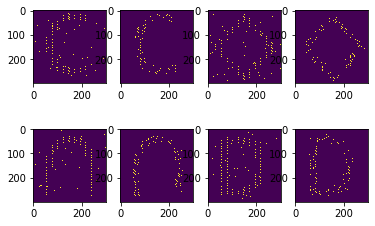

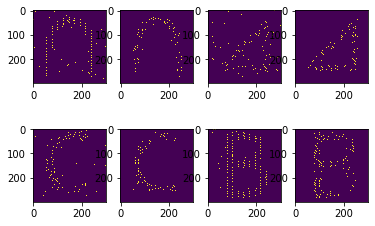

<Figure size 432x288 with 0 Axes>

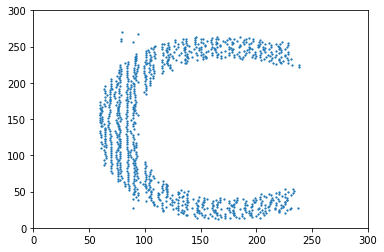

<Figure size 432x288 with 0 Axes>

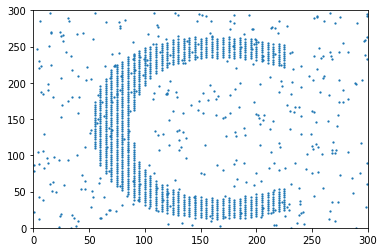

In [15]:
fig, axs = plt.subplots(2, 4)
axs[0, 0].imshow(input_list[0][0])
axs[0, 1].imshow(output_list[0][0])

axs[1, 0].imshow(input_list[0][1])
axs[1, 1].imshow(output_list[0][1])

axs[0, 2].imshow(input_list[0][2])
axs[0, 3].imshow(output_list[0][2])

axs[1, 2].imshow(input_list[0][3])
axs[1, 3].imshow(output_list[0][3])

fig, axs = plt.subplots(2, 4)
axs[0, 0].imshow(input_list[0][25])
axs[0, 1].imshow(output_list[0][25])

axs[1, 0].imshow(input_list[0][26])
axs[1, 1].imshow(output_list[0][26])

axs[0, 2].imshow(input_list[0][23])
axs[0, 3].imshow(output_list[0][23])

axs[1, 2].imshow(input_list[0][27])
axs[1, 3].imshow(output_list[0][27])

plt.figure()
utilities.plot_raster_dot(output_list[0][0])
plt.figure()
utilities.plot_raster_dot(input_list[0][0])